In [1]:
#import pairs_backtest as pb
import talib 
import numpy as np
import datetime as dt #in-built module
import pandas as pd
from pandas_datareader import data
import yfinance as yf
from yahoo_fin import stock_info as si
import matplotlib.pyplot as plt
from matplotlib import style
from pathlib import Path
import os
from tqdm import tqdm   
from pairs_backtest import kalman_lib as kalman
from pairs_backtest import find_pairs
from pairs_backtest import utils
from pandas_datareader import data as pdr
import statsmodels.tsa.stattools as ts 
import seaborn as sns
import statsmodels.api as sm

In [2]:
def get_data(code,start,end):
    data = yf.Ticker(code)
    data = data.history(start = start, end = end)
    #data.index = data.index.strftime('%d/%m/%Y')
    return data

In [3]:
pairs = pd.read_csv('pairs_2023_11_26.csv')


In [4]:
date = dt.datetime.now()
date ='%s_%s_%s'%(date.year,date.month,date.day)
backtest_day = 7300
start = dt.datetime.now()- dt.timedelta(days=backtest_day)
#end = dt.datetime.now()
#start = pd.Timestamp('2012-01-01')
#end = pd.Timestamp('2020-03-05')
end = dt.date.today()


In [5]:
combin_df_index = get_data('SPY',start,end).index
combin_df_index

DatetimeIndex(['2004-01-13 00:00:00-05:00', '2004-01-14 00:00:00-05:00',
               '2004-01-15 00:00:00-05:00', '2004-01-16 00:00:00-05:00',
               '2004-01-20 00:00:00-05:00', '2004-01-21 00:00:00-05:00',
               '2004-01-22 00:00:00-05:00', '2004-01-23 00:00:00-05:00',
               '2004-01-26 00:00:00-05:00', '2004-01-27 00:00:00-05:00',
               ...
               '2023-12-21 00:00:00-05:00', '2023-12-22 00:00:00-05:00',
               '2023-12-26 00:00:00-05:00', '2023-12-27 00:00:00-05:00',
               '2023-12-28 00:00:00-05:00', '2023-12-29 00:00:00-05:00',
               '2024-01-02 00:00:00-05:00', '2024-01-03 00:00:00-05:00',
               '2024-01-04 00:00:00-05:00', '2024-01-05 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=5030, freq=None)

In [6]:
def check_if_have_signal(df):
  unique_value = set(df.numUnits.unique())
  return unique_value

if not os.path.exists('for_testing'):
  os.makedirs('for_testing')
#first_inst = 'GDX'
#second_inst = 'JPM'
combin_df = pd.DataFrame(index = combin_df_index)
pair_score = []

for pair in pairs.iterrows():
  x_df = get_data(pair[1]['s1'],start,end)
  y_df = get_data(pair[1]['s2'],start,end)
  common_index = (x_df.index).intersection(y_df.index)
  x_df = x_df.loc[common_index].copy()
  y_df = y_df.loc[common_index].copy()
  df, sharpe, _ = kalman.backtest(x_df.Close, y_df.Close) #df1 = x; df2 = y
  df = df.iloc[:-1,:]


  half_life = kalman.half_life(df['spread'])

  unique_signal = check_if_have_signal(df)

  result = ts.coint(((x_df['Close'])),(y_df['Close']))
  score = result[0]
  pvalue = result[1]
  #print('Score:', score)
  #print('pvalue:', pvalue)

  adf = kalman.adf_test(df)
  #print(adf)
  if np.isnan(sharpe) or ( unique_signal == {np.nan, 0} or (len(df) < 365 )) :
    print('pass because of sharpe ratio with Nan / No any signals generated/ too short')
    continue

  name_of_pair = pair[1]['s1'] + '_' + pair[1]['s2']
  pair_score.append([name_of_pair,score,pvalue, len(df),adf, df.iloc[-1]['cum rets'],unique_signal])
  df_pair_score = pd.DataFrame(pair_score, columns=['pairs','coint score','coint p-value','len','adf p-value','final_cum_rets','signal'])
  
  #df = df.dropna()
  df.to_csv('for_testing/%s.csv'%(name_of_pair))
  print ('%s vs %s has sharp ratio of %0.2f' %(pair[1]['s1'],pair[1]['s2'],sharpe))
  
  df['cum rets'] = df['cum rets'].fillna(1)

  #combin_df[pair[1]['s1']+'_'+pair[1]['s2']+'cum rets'] = df['cum rets'].fillna(1).copy()
  df.rename(columns={"cum rets": name_of_pair+'_'+'cum rets'}, inplace = True)
  combin_df = pd.concat([combin_df,df[name_of_pair+ '_'+'cum rets']],axis = 1)


pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because of sharpe ratio with Nan / No any signals generated/ too short
pass because

In [7]:
combin_df

,EQIX_SPGI_cum rets,EQIX_MCO_cum rets,CRM_SPGI_cum rets,KEY_MSCI_cum rets,HIG_LIN_cum rets,HIG_HLT_cum rets,CRM_MCO_cum rets,CRM_EQIX_cum rets,ED_IFF_cum rets,REG_WY_cum rets,...,IFF_XEL_cum rets,ADSK_AMP_cum rets,ATO_MGM_cum rets,TFC_WEC_cum rets,DOW_EIX_cum rets,FITB_SPG_cum rets,FITB_WY_cum rets,KR_O_cum rets,PSA_WYNN_cum rets,CSCO_TRV_cum rets
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-13 00:00:00-05:00,1.000000,1.000000,NaN,NaN,1.000000,NaN,NaN,NaN,1.000000,1.000000,...,1.000000,NaN,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
2004-01-14 00:00:00-05:00,1.000000,1.000000,NaN,NaN,1.000000,NaN,NaN,NaN,1.000000,1.000000,...,1.000000,NaN,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
2004-01-15 00:00:00-05:00,1.000000,1.000000,NaN,NaN,1.000000,NaN,NaN,NaN,1.000000,1.000000,...,1.000000,NaN,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
2004-01-16 00:00:00-05:00,1.000000,1.000000,NaN,NaN,1.000000,NaN,NaN,NaN,1.000000,1.000000,...,1.000000,NaN,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
2004-01-20 00:00:00-05:00,1.000000,1.000000,NaN,NaN,1.000000,NaN,NaN,NaN,1.000000,1.000000,...,1.000000,NaN,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29 00:00:00-05:00,6.095002,6.854459,7.045513,5.003495,6.284008,3.984910,7.975666,8.356061,5.132551,5.520255,...,5.143462,6.674509,7.499479,5.121274,2.558533,6.653229,6.204939,5.555772,8.720700,5.864756
2024-01-02 00:00:00-05:00,6.103176,6.854459,7.045513,5.019254,6.277477,3.996598,7.975666,8.356061,5.138336,5.525892,...,5.143462,6.691875,7.499479,5.121274,2.558533,6.653229,6.204939,5.555772,8.720700,5.864756
2024-01-03 00:00:00-05:00,6.103176,6.854917,7.045513,5.011779,6.277545,3.996598,7.975666,8.357007,5.138336,5.523176,...,5.134436,6.691875,7.499479,5.121274,2.558533,6.653229,6.204939,5.555772,8.720700,5.864756


In [8]:
#concatenate together the individual equity curves into a single DataFrame
results_df = combin_df.dropna(axis=1)
#results_df = combin_df.fillna(1)

#equally weight each equity curve by dividing each by the number of pairs held in the DataFrame
results_df /= len(results_df.columns)
print('num of pairs:',len(results_df.columns))

#sum up the equally weighted equity curves to get our final equity curve
final_res = results_df.sum(axis=1)

# square root of sample size for correct number of bins for returns distribution
print('Bin Count =', np.sqrt(len(final_res)))

num of pairs: 151
Bin Count = 70.92249290598858


Text(0, 0.5, 'Returns')

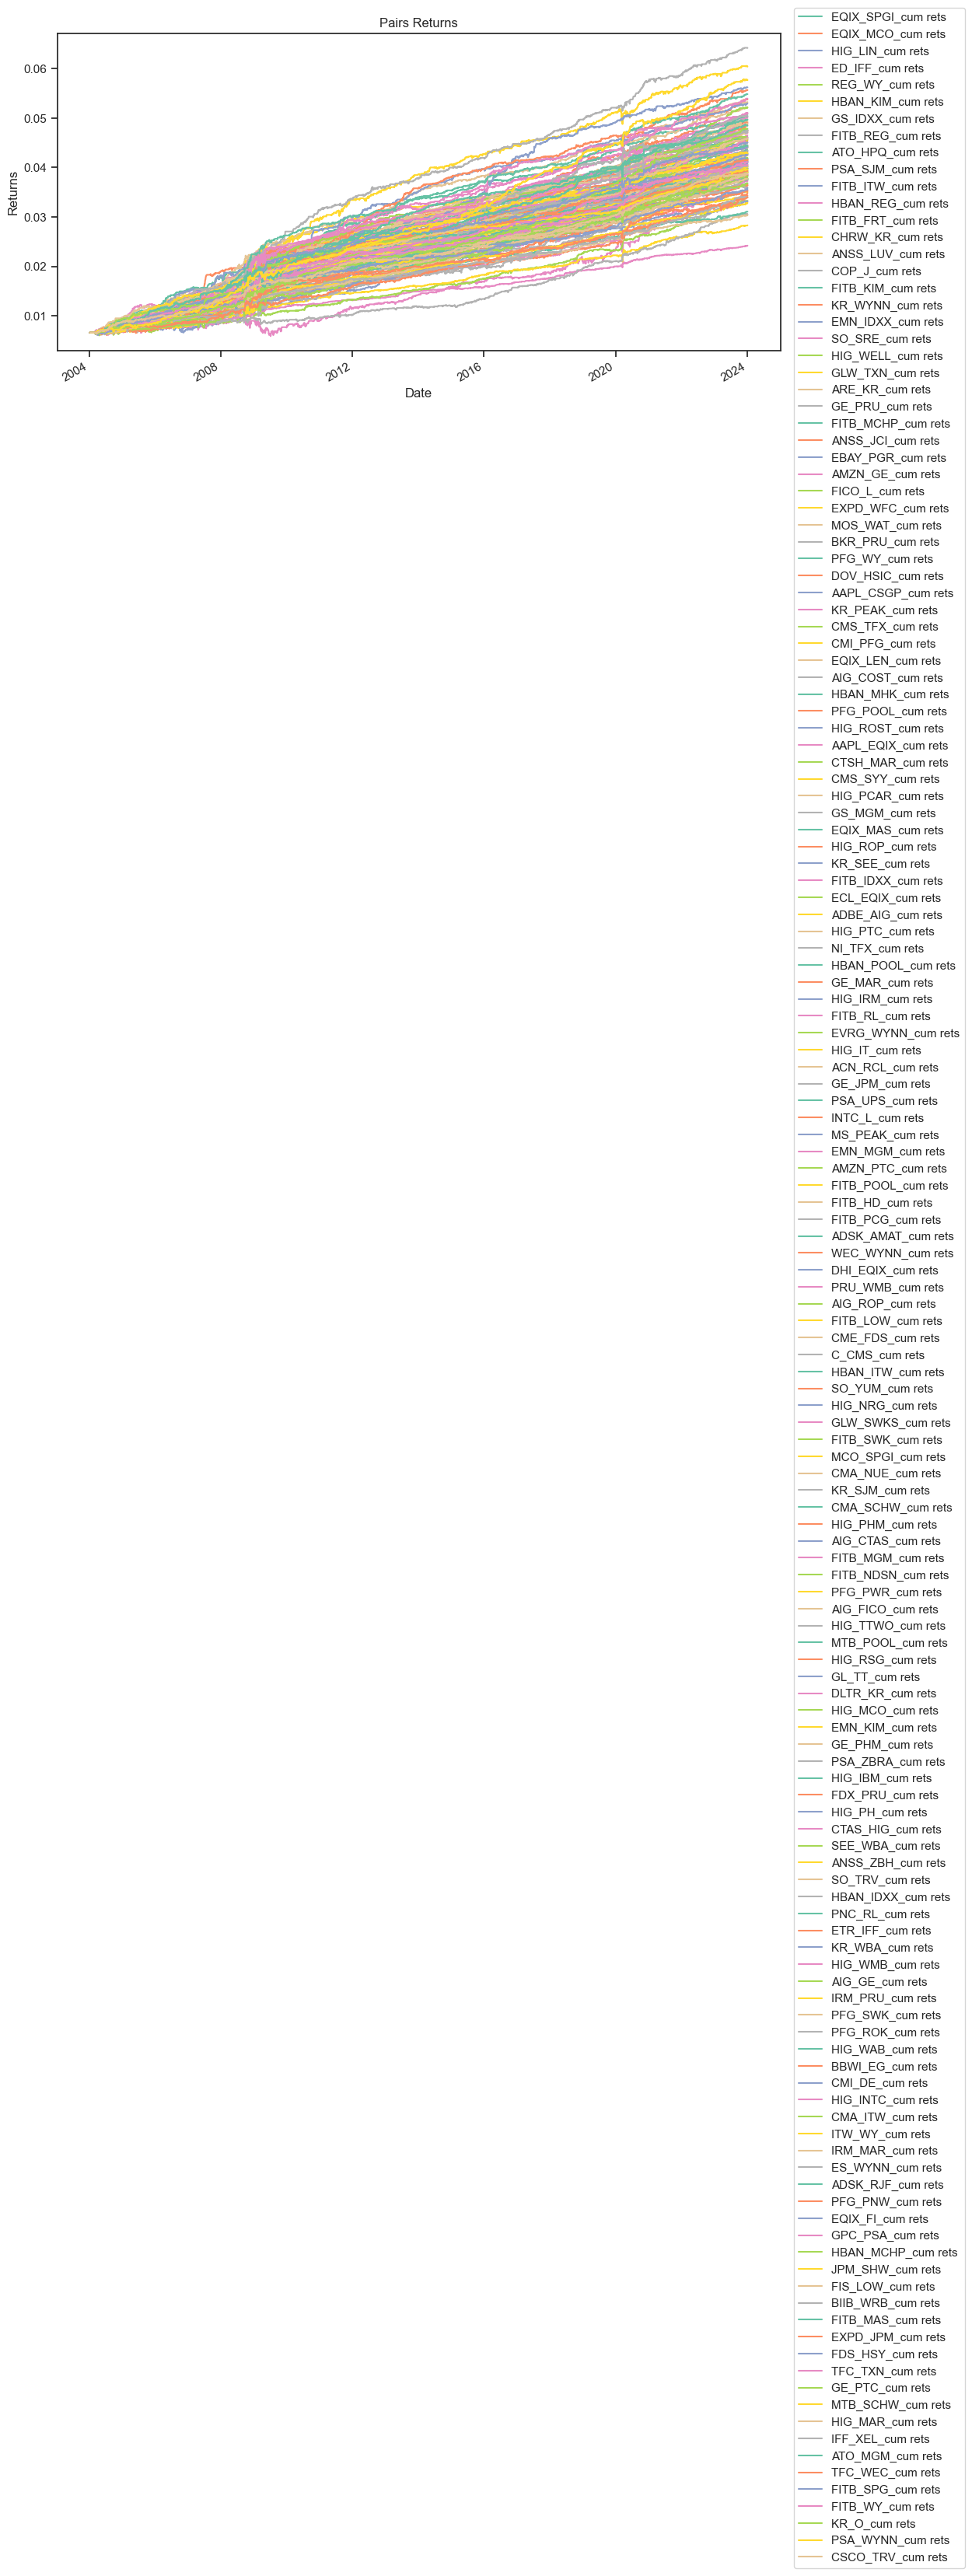

In [9]:
results_df.plot(figsize=(12,6),legend=True)
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
#plt.grid(b=None, which=u'major', axis=u'both')
plt.title('Pairs Returns')
plt.xlabel('Date')
plt.ylabel('Returns')

In [10]:
combin_df.dropna(axis=1).shape

(5030, 151)

In [11]:
import ffn
Pair_Rets = ffn.to_returns(final_res)
Pair_Rets = pd.DataFrame(Pair_Rets)
Pair_Rets = Pair_Rets.fillna(0)
Pair_Rets.columns = ['Pairs_Returns']

In [12]:
perf = final_res.calc_stats()

In [13]:
num_pairs = len(results_df.columns)
print('Number of Pairs =', num_pairs)

Number of Pairs = 151


In [14]:
bench = get_data('SPY',start,end)['Close'].pct_change().dropna()

In [15]:
Pair_Rets0 = Pair_Rets.loc[str(bench.index[0]):str(bench.index[-1])]

h:\anaconda\envs\backtest\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(
h:\anaconda\envs\backtest\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2004-01-14
End date,2024-01-05
Total months,239
,Backtest
Annual return,9.736%
Cumulative returns,538.591%
Annual volatility,1.494%
Sharpe ratio,6.23
Calmar ratio,9.99
Stability,0.92
Max drawdown,-0.974%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.97,2008-12-15,2008-12-17,2008-12-22,6
1,0.92,2009-03-31,2009-04-13,2009-04-20,15
2,0.89,2009-04-28,2009-05-08,2009-05-12,11
3,0.76,2009-01-28,2009-02-04,2009-02-09,9
4,0.76,2008-06-10,2008-06-18,2008-06-25,12


h:\anaconda\envs\backtest\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
h:\anaconda\envs\backtest\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
h:\anaconda\envs\backtest\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
h:\anaconda\envs\backtest\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly t

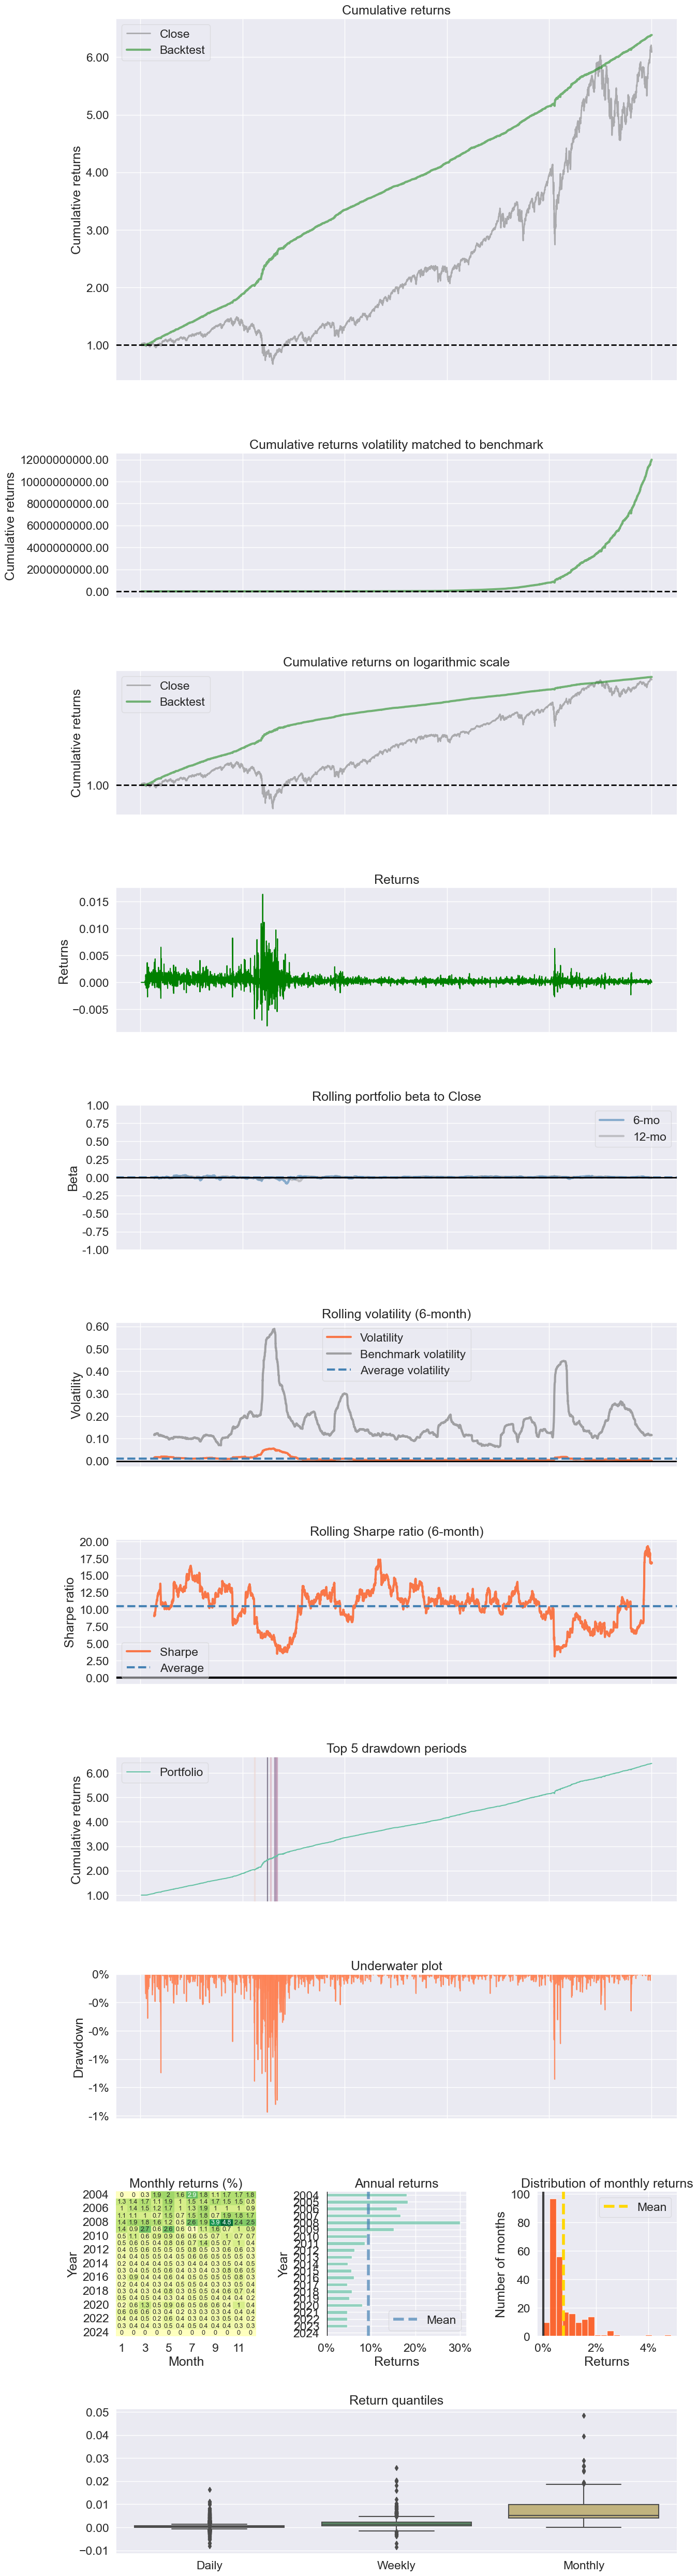

In [16]:
import pyfolio as pf
fig = pf.create_returns_tear_sheet(Pair_Rets.Pairs_Returns, benchmark_rets=bench, return_fig= True)
fig.savefig('porfolio_report/%s'%(end.strftime('%Y_%m_%d')))

In [17]:
Pair_Rets.mean().values[0]

0.0003691164119619028

C:\Users\IsaacPC\AppData\Local\Temp\ipykernel_13224\3939018212.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Pair_Rets, hist = True, kde = True, bins=35,


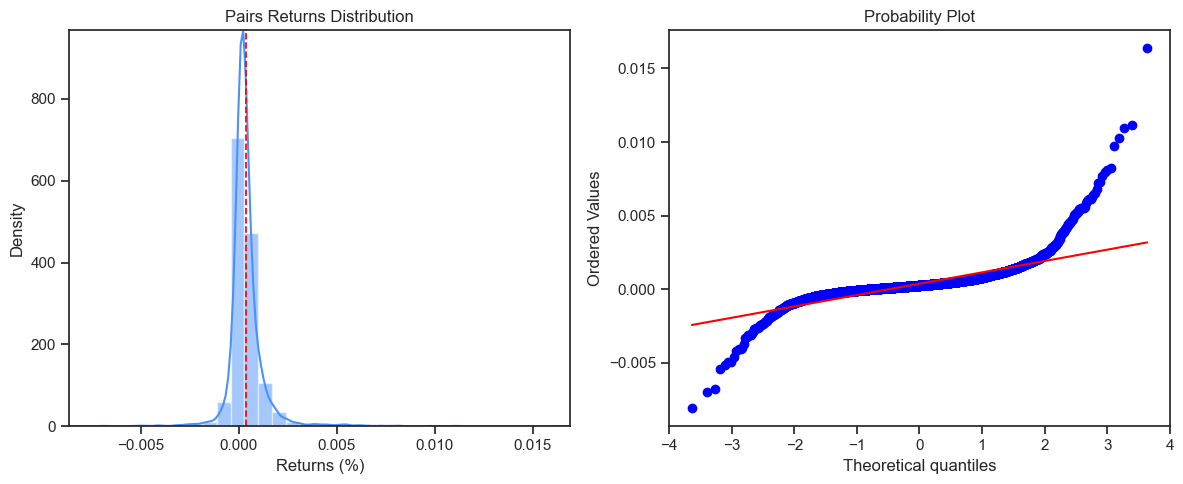

In [18]:
from scipy import stats


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))

sns.distplot(Pair_Rets, hist = True, kde = True, bins=35,
                 hist_kws = {'linewidth': 1, 'alpha':.5},
                 label='Pairs Returns', color='#4b91fa', ax=ax1)

ax1.axvline(x=Pair_Rets.mean().values[0], color='#ff0000', linewidth=1.25, linestyle='dashed',label = 'Returns Mean')

ax1.set_title('Pairs Returns Distribution')
ax1.margins(0.001)
ax1.set_xlabel('Returns (%)')
ax1.set_ylabel('Density')

stats.probplot(Pair_Rets.Pairs_Returns, plot=ax2)

plt.tight_layout()

plt.show()

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

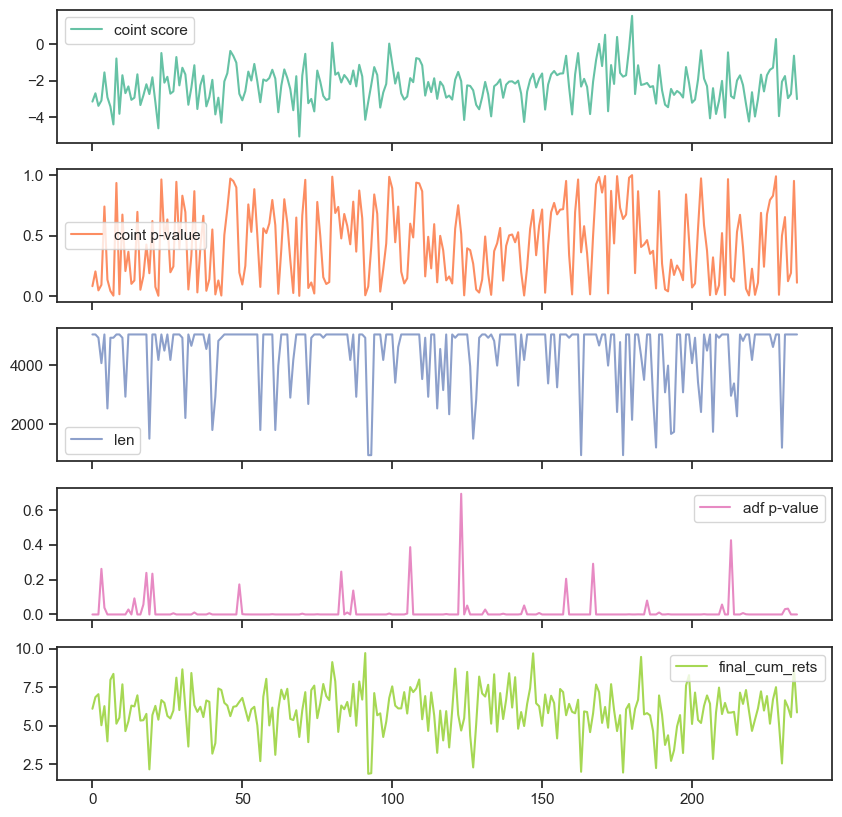

In [19]:
df_pair_score.plot(figsize=(10,10),subplots=True)

Check the distribution of len

C:\Users\IsaacPC\AppData\Local\Temp\ipykernel_13224\4095186782.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_pair_score.len, hist = True, kde = True, bins=35,


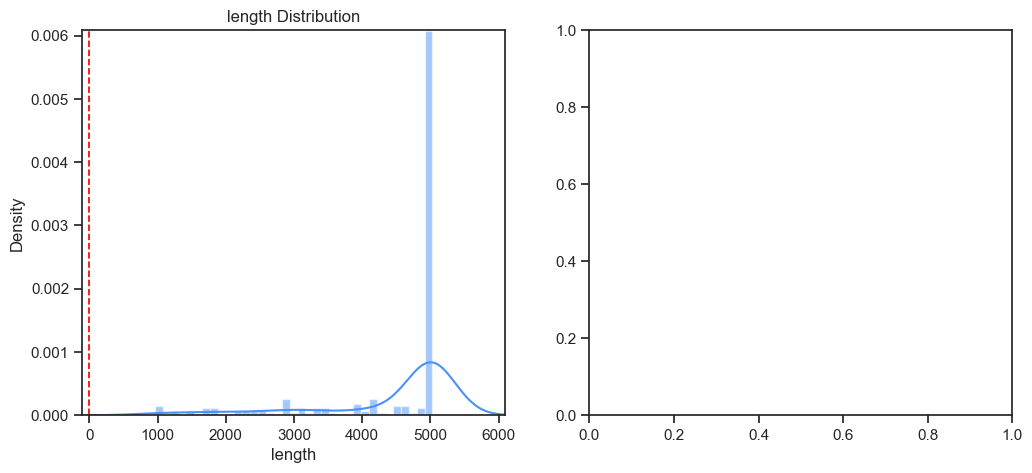

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))

sns.distplot(df_pair_score.len, hist = True, kde = True, bins=35,
                 hist_kws = {'linewidth': 1, 'alpha':.5},
                 label='Pairs Returns', color='#4b91fa', ax=ax1)

ax1.axvline(x=Pair_Rets.mean().values[0], color='#ff0000', linewidth=1.25, linestyle='dashed',label = 'Returns Mean')

ax1.set_title('length Distribution')
ax1.margins(0.001)
ax1.set_xlabel('length')
ax1.set_ylabel('Density')

plt.show()

Check correlation

In [21]:
corr = df_pair_score.corr()
corr.style.background_gradient(cmap='coolwarm')


,coint score,coint p-value,len,adf p-value,final_cum_rets
coint score,1.000000,0.952840,0.059586,0.016267,0.181958
coint p-value,0.952840,1.000000,0.135020,0.011943,0.225228
len,0.059586,0.135020,1.000000,0.056621,0.720400
adf p-value,0.016267,0.011943,0.056621,1.000000,-0.017425
final_cum_rets,0.181958,0.225228,0.720400,-0.017425,1.000000


h:\anaconda\envs\backtest\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='adf p-value', ylabel='final_cum_rets'>

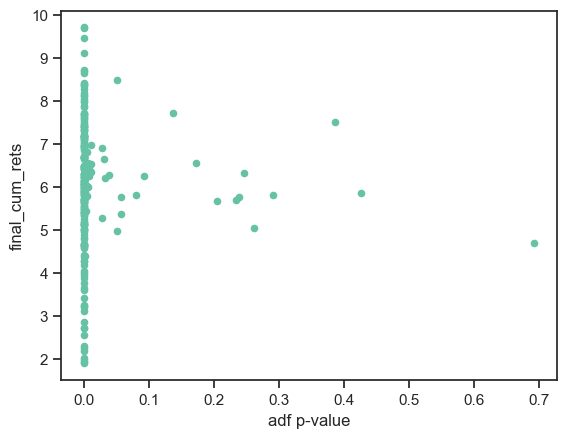

In [22]:
df_pair_score.plot.scatter(x='adf p-value', y='final_cum_rets')

In [23]:
df_pair_score.describe()

,coint score,coint p-value,len,adf p-value,final_cum_rets
count,236.000000,236.000000,236.000000,2.360000e+02,236.000000
mean,-2.251168,0.430060,4477.377119,1.669895e-02,6.015450
std,1.012667,0.312834,1049.453668,7.125151e-02,1.463288
min,-5.044166,0.000136,957.000000,3.414743e-30,1.896061
25%,-2.930696,0.127612,4526.000000,8.160937e-20,5.334418
50%,-2.205422,0.421572,5030.000000,6.934910e-14,6.067245
75%,-1.689649,0.681610,5030.000000,1.245013e-05,6.948779
max,1.525202,1.000000,5030.000000,6.925677e-01,9.705682


In [24]:
df_pair_score[df_pair_score['final_cum_rets']==1]

,pairs,coint score,coint p-value,len,adf p-value,final_cum_rets,signal


In [25]:
df_pair_score['signal']

0      {nan, 0.0, -1.0, 1.0}
1      {nan, 0.0, -1.0, 1.0}
2      {nan, 1.0, 0.0, -1.0}
3      {nan, 1.0, 0.0, -1.0}
4      {nan, 0.0, -1.0, 1.0}
               ...          
231    {nan, 0.0, 1.0, -1.0}
232    {nan, 0.0, -1.0, 1.0}
233    {nan, 0.0, -1.0, 1.0}
234    {nan, 1.0, 0.0, -1.0}
235    {nan, 0.0, 1.0, -1.0}
Name: signal, Length: 236, dtype: object

h:\anaconda\envs\backtest\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='adf p100', ylabel='final_cum_rets'>

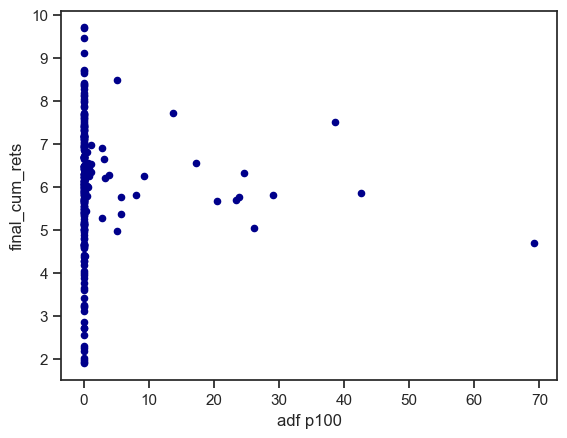

In [26]:
df_pair_score['adf p100'] = df_pair_score['adf p-value']*100
df_pair_score.plot.scatter(x='adf p100',
                      y='final_cum_rets',
                      c='DarkBlue')

In [27]:
df_pair_score['adf p-value']

0      4.047956e-22
1      9.109942e-23
2      2.410698e-29
3      2.616785e-01
4      3.868613e-02
           ...     
231    3.067677e-02
232    3.339960e-02
233    1.384979e-04
234    3.118267e-29
235    8.584387e-05
Name: adf p-value, Length: 236, dtype: float64